# FNN

# 1. Load dataset
+ over sampled dataset

In [61]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor, Lambda
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NanumMyeongjo.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(15,15))
plt.rc('font', size=13)
plt.style.use('ggplot')

In [77]:
ds_train = pd.read_csv('train.csv', encoding='euc-kr')

In [78]:
ds_test = pd.read_csv('test.csv', encoding='euc-kr')

In [79]:
ds_train.iloc[:,-1].value_counts()

0    43009
1    43009
Name: 평가일이후최초부실발생, dtype: int64

### 1.1 Customizing dataset pandas dataframe to tensor fo pytorch

In [80]:
class CustomDataset(Dataset):
    def __init__(self, df, predictors, target):
        X = df[predictors].values
        y = df[target].values
        self.X = torch.tensor(X,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = len(df)
    def __getitem__(self, idx):
        return self.X[idx],self.y[idx]
    def __len__(self):
        return self.length

In [81]:
predictors = ['설립기간', '상시직원수', '기업규모코드', '주요사업장담보제공여부', '주사업장담보설정금액',
       '주요사업장건물규모면적', '주요사업장대지규모면적', '주요사업장월세금액', '주요사업장전세금액',
       '주요사업장자가소유권리침해코드', '대표자소유권리침해구분코드', '대표자소유담보제공여부', '대표자소유담보설정금액',
       '평가모형코드', '운전자금합계금액', '무역금융합계금액', '할인어음합계금액', '지급보증합계금액', '시설대여합계금액',
       '총차입금합계금액', '최근매출실적', '당기매출실적', '전기매출실적']
target = '평가일이후최초부실발생'

In [85]:
cds_train = CustomDataset(ds_train, predictors, target)
cds_test = CustomDataset(ds_test, predictors, target)

In [86]:
print(f"Training Data Size : {len(cds_train)}")
print(f"Testing Data Size : {len(cds_test)}")

Training Data Size : 86018
Testing Data Size : 19189


In [89]:
train_dataloader = DataLoader(cds_train, batch_size=200, shuffle=True, drop_last=True)
test_dataloader = DataLoader(cds_test, batch_size=400, shuffle=True, drop_last=True)

In [90]:
device = "cuda" if torch.cuda.is_available() else "cpu" # gpu 사용

## 2. FNN
### 2.1 Setting
+ hyperparams:
    - layer 1 : 23x128, layer 2 : 128x128, layer 3 : 128x1
    - activation fucntion : ReLU
    - drop out : prob=0.1
    - batch size : 200
    - learning rate : 0.001
    - epochs : 30

In [123]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(23, 128) 
        self.layer_2 = nn.Linear(128, 128)
        self.layer_out = nn.Linear(128, 1) 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.dropout(x)
        x = self.layer_out(x)
        return x
    
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [124]:
# hyperparams
epochs = 30
learning_rate =0.001

### 2.2 Fitting

In [125]:
torch.autograd.set_detect_anomaly(True)
model = BinaryClassification()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

history=[] # loss history
model.train()
for e in range(1, epochs+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        #print(y_pred)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        #print(loss)
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    history.append(epoch_loss/len(train_dataloader))
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_dataloader):.5f} | Acc: {epoch_acc/len(train_dataloader):.3f}')

Epoch 001: | Loss: 1675.36771 | Acc: 52.786
Epoch 002: | Loss: 663.28136 | Acc: 54.716
Epoch 003: | Loss: 606.62909 | Acc: 53.388
Epoch 004: | Loss: 227.42625 | Acc: 54.965
Epoch 005: | Loss: 211.11183 | Acc: 54.835
Epoch 006: | Loss: 89.13452 | Acc: 54.574
Epoch 007: | Loss: 23.68973 | Acc: 56.319
Epoch 008: | Loss: 17.53708 | Acc: 57.123
Epoch 009: | Loss: 5.60075 | Acc: 57.726
Epoch 010: | Loss: 0.71849 | Acc: 59.298
Epoch 011: | Loss: 0.65535 | Acc: 60.321
Epoch 012: | Loss: 24.29015 | Acc: 58.877
Epoch 013: | Loss: 3.95093 | Acc: 57.072
Epoch 014: | Loss: 0.67386 | Acc: 58.470
Epoch 015: | Loss: 0.64781 | Acc: 59.844
Epoch 016: | Loss: 0.63858 | Acc: 60.879
Epoch 017: | Loss: 301.13782 | Acc: 57.677
Epoch 018: | Loss: 11.68480 | Acc: 58.349
Epoch 019: | Loss: 0.64229 | Acc: 61.772
Epoch 020: | Loss: 0.64683 | Acc: 62.567
Epoch 021: | Loss: 0.82565 | Acc: 63.188
Epoch 022: | Loss: 0.61116 | Acc: 64.047
Epoch 023: | Loss: 0.60260 | Acc: 64.519
Epoch 024: | Loss: 0.59333 | Acc: 65.01

### 2.3 Loss plot

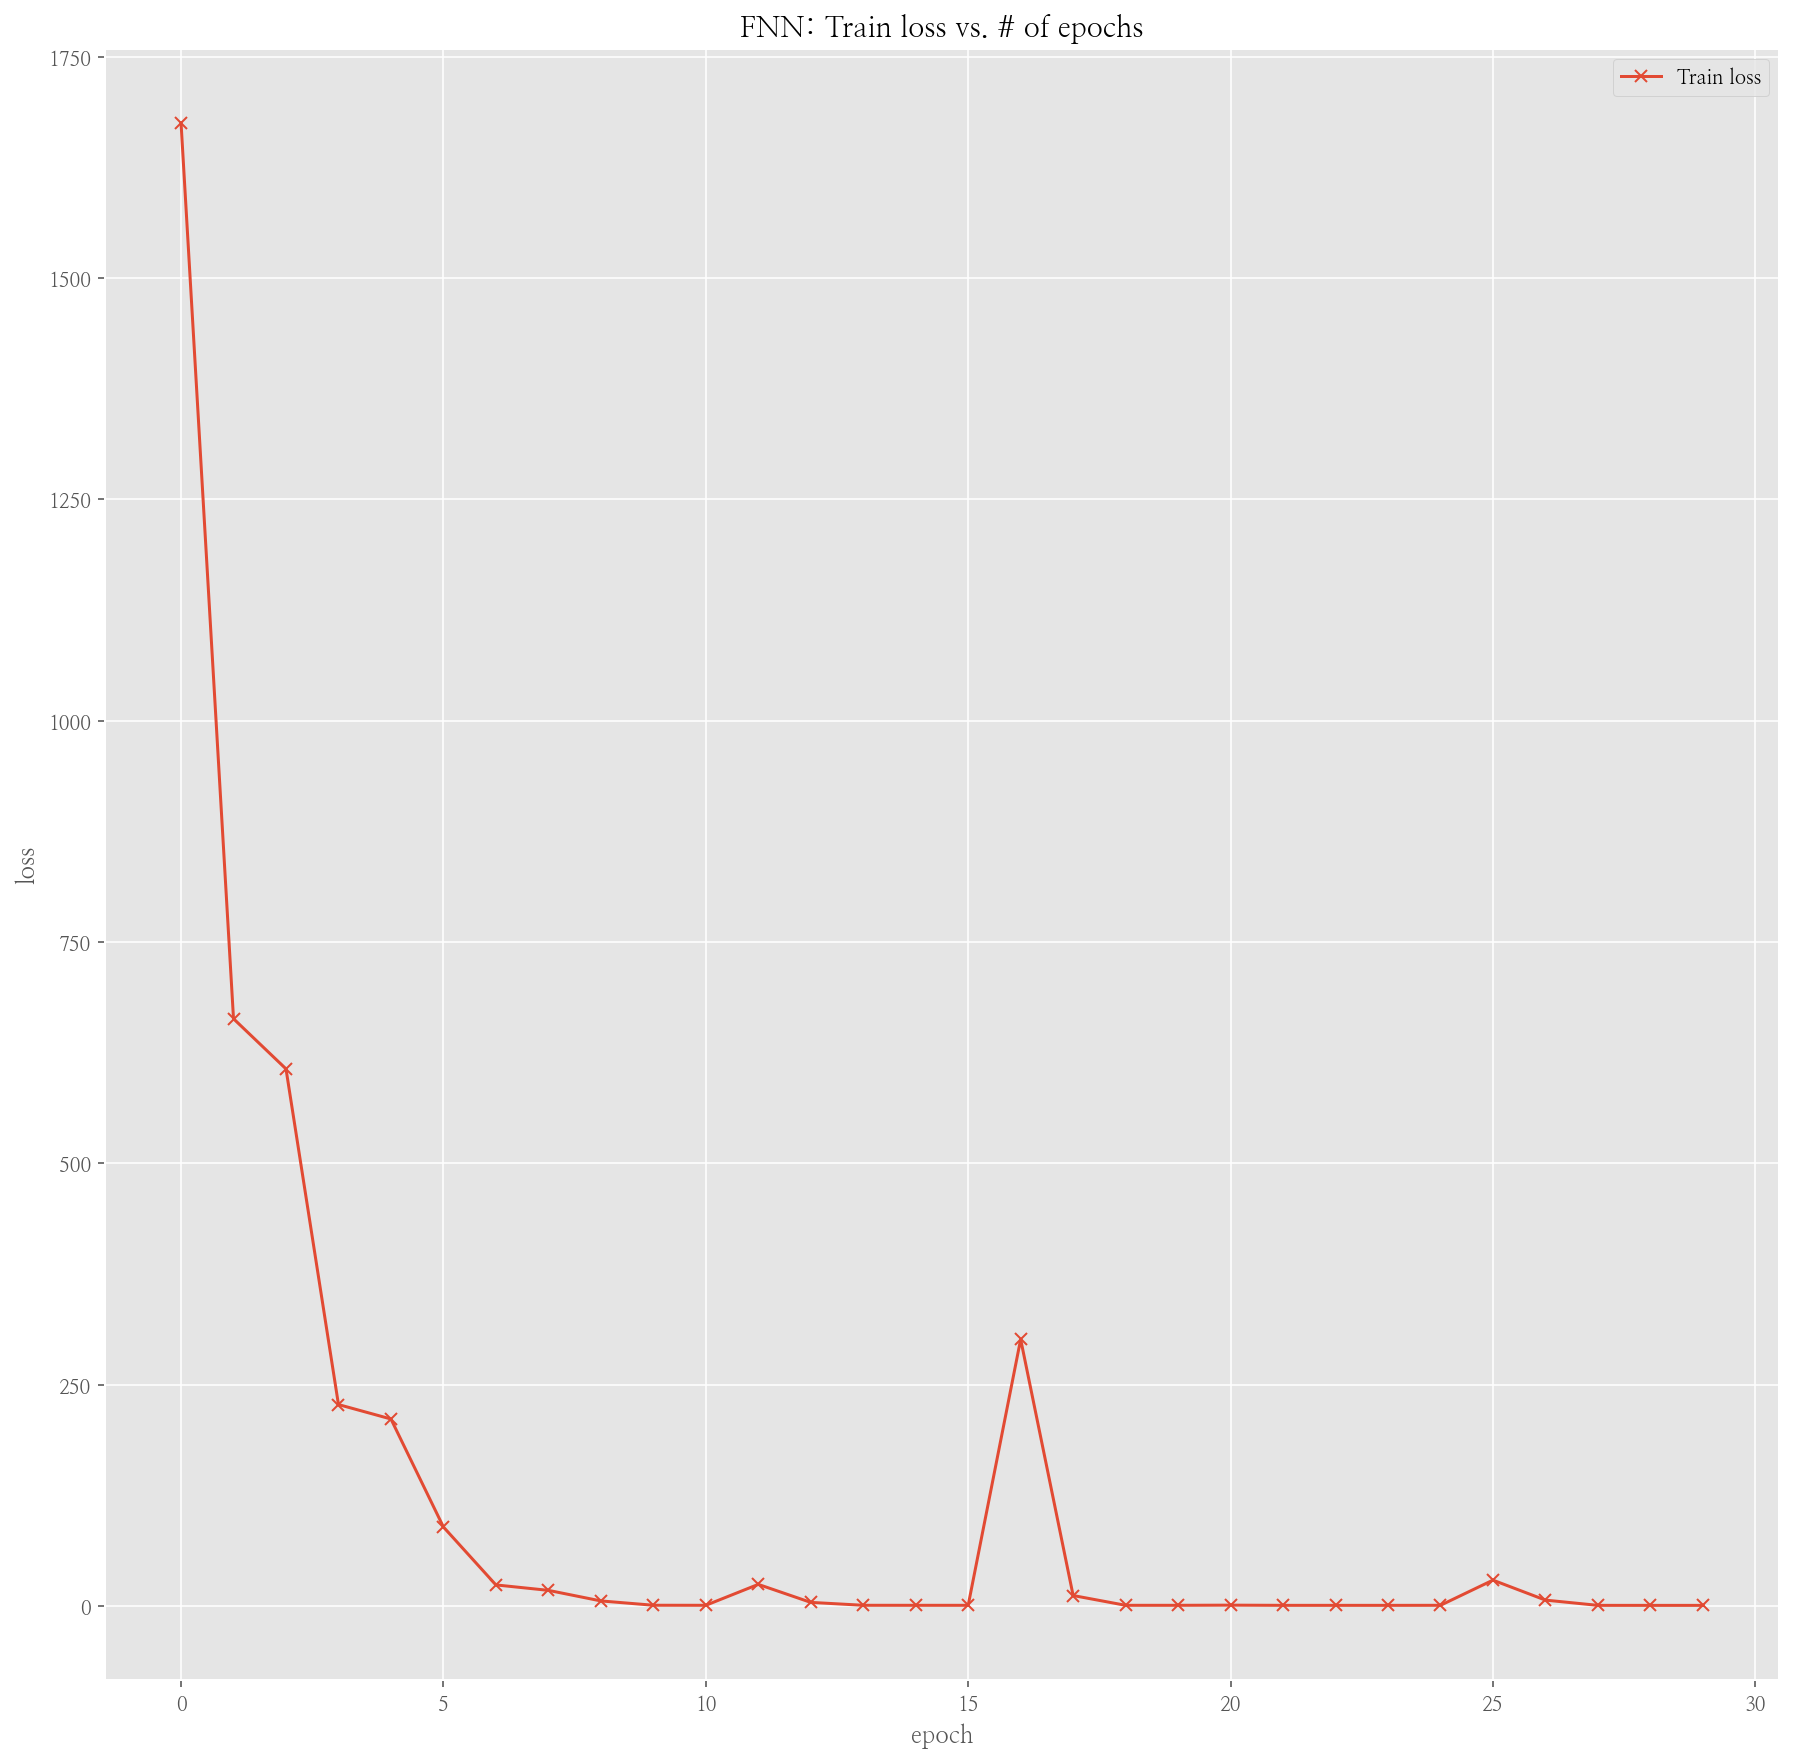

In [126]:
def plot_loss(history, name):
    fig = plt.figure()
    plt.plot(history, '-x', label='Train loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('{}: Train loss vs. # of epochs'.format(name))
    plt.savefig('loss_{}.png'.format(name),dpi=300)
plot_loss(history, 'FNN')

## 3. Predictive performance
    + ACC, recall, AUC, confusion matrix

In [127]:
y_pred_list = []
y_test_list = []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_dataloader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.extend(y_pred_tag.data.cpu().numpy())
        y_test_list.extend(y_batch.unsqueeze(1).data.cpu().numpy()) # Save Truth

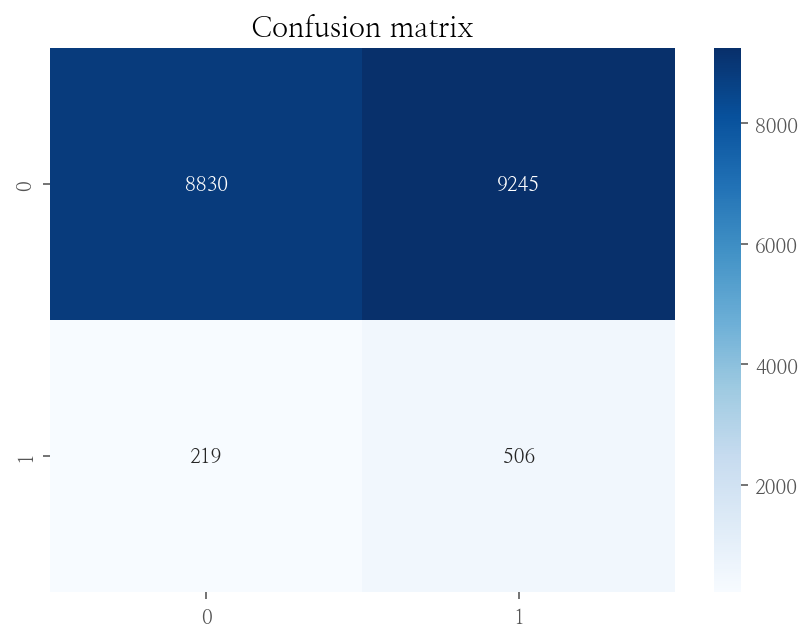

In [128]:
from sklearn.metrics import confusion_matrix, classification_report
classes = [0,1]
cf_matrix = confusion_matrix(y_test_list, y_pred_list)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, cmap='Blues',fmt=".0f")
plt.title('Confusion matrix');
plt.savefig('confusion_matrix.png',dpi=300)

In [132]:
print(classification_report(y_test_list, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.98      0.49      0.65     18075
         1.0       0.05      0.70      0.10       725

    accuracy                           0.50     18800
   macro avg       0.51      0.59      0.37     18800
weighted avg       0.94      0.50      0.63     18800



In [133]:
from sklearn.metrics import roc_auc_score
pred_proba = y_pred_list
auc_score = roc_auc_score(y_test_list, pred_proba)
auc_score

0.5932255449038966

In [134]:
from sklearn.metrics import accuracy_score, f1_score
accuracy_score(y_test_list, y_pred_list)


0.49659574468085105

In [135]:
f1_score(y_test_list, y_pred_list)

0.09660175639557084